# How to debug a model

There are various levels on which to debug a model. One of the simplest is to just print out the values that different variables are taking on.

Because `PyMC3` uses `Theano` expressions to build the model, and not functions, there is no way to place a `print` statement into a likelihood function. Instead, you can use the `Theano` `Print` operatator. For more information, see:  theano Print operator for this before: http://deeplearning.net/software/theano/tutorial/debug_faq.html#how-do-i-print-an-intermediate-value-in-a-function.

Let's build a simple model with just two parameters:

 [-----------------100%-----------------] 5000 of 5000 complete in 0.8 sec

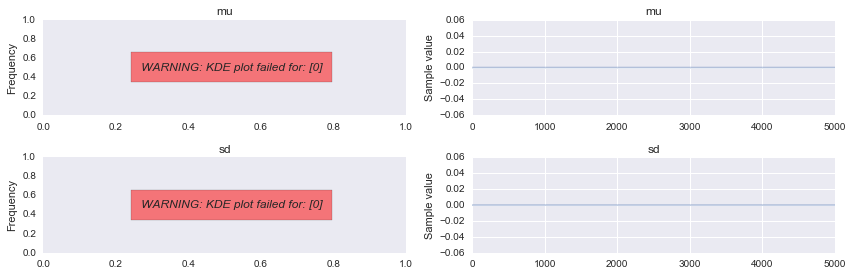

In [1]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import theano.tensor as T

x = np.random.randn(100)

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.Normal('sd', mu=0, sd=1)

    obs = pm.Normal('obs', mu=mu, sd=sd, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(5000, step)
pm.traceplot(trace);

Hm, looks like something has gone wrong, but what? Let's look at the values getting proposed using the `Print` operator:

In [2]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.Normal('sd', mu=0, sd=1)
    
    mu_print = T.printing.Print('mu')(mu)
    sd_print = T.printing.Print('sd')(sd)
    
    obs = pm.Normal('obs', mu=mu_print, sd=sd_print, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(3, step) # Make sure not to draw too many samples

mu __str__ = 0.0
sd __str__ = 0.0
sd __str__ = -1.4315792219864252
mu __str__ = 0.0
sd __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 1.3615472322158946
mu __str__ = 0.0
sd __str__ = 0.5322478998286673
mu __str__ = 0.0
sd __str__ = 0.0
sd __str__ = 0.0
mu __str__ = -1.2753319093167306
mu __str__ = 0.0
sd __str__ = -0.4843153880482674
mu __str__ = 0.0
sd __str__ = 0.0
sd __str__ = 0.0
mu __str__ = -0.4478412022208693
mu __str__ = 0.0
 [-----------------100%-----------------] 3 of 3 complete in 0.0 sec

Looks like `sd` is always `0` which will cause the logp to go to `-inf`. Of course, we should not have used a prior that has negative mass for `sd` but instead something like a `HalfNormal`.

We can also redirect the output to a string buffer and access the proposed values later on (thanks to [Lindley Lentati](https://github.com/LindleyLentati) for providing this example):

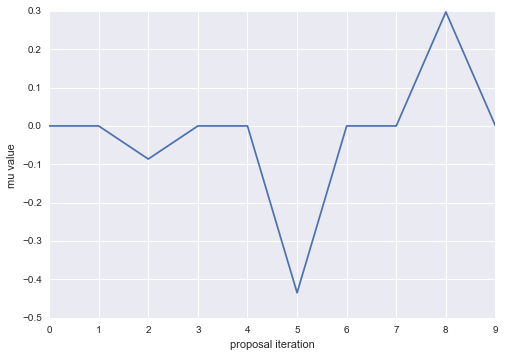

In [9]:
from io import StringIO
import sys


x = np.random.randn(100)


old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.Normal('sd', mu=0, sd=1)

    mu_print = T.printing.Print('mu')(mu)
    sd_print = T.printing.Print('sd')(sd)

    obs = pm.Normal('obs', mu=mu_print, sd=sd_print, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(3, step) # Make sure not to draw too many samples


sys.stdout = old_stdout

output = mystdout.getvalue().split('\n')
mulines = [s for s in output if 'mu' in s]

muvals = [line.split()[-1] for line in mulines]
plt.plot(np.arange(0,len(muvals)), muvals);
plt.xlabel('proposal iteration')
plt.ylabel('mu value')